# Cross Model Validation (i.e. Double cross validation)

## What is Cross-Model Validation?
* **Cross-Model Validation** compares the performance of multiple machine learning models on the same dataset.
* It ensures that the selected model is the best fit by evaluating different models in the same evaluation metric

## Why use Cross-Model Validation?
* **Model Comparison:** Helps in selecting the most effective model for a case
* **Evaluation Consistency:** All models are evaluated on the same dataset and conditions
* **Informed Decision:** Ensures the model chosen is the one that generalizes the best

# What is Double Cross Validation?
* Combines two nested cross-validation loops.
    * **Outer loop**: Used for model evaluation
    * **Inner loop**: Used for hyperparameter tuning.

* Allows evaluation of multiple models which are hyperparameter tuned using inner cross validation. 

# Steps in Cross-Model Validation

1. Outer Cross-validation: Split data into training and test (Validation) sets.
2. Inner Cross-validation: Tune model hyperparameters within the training data of the outer fold.
3. Evaluation: test the model on the outer test fold after tuning.


# Example on prediction of output power by different models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# Generate synthetic dataset
np.random.seed(50)
n_samples = 300

flow_rate = np.random.uniform(50, 300, n_samples)
head = np.random.uniform(30, 80, n_samples)
efficiency = np.random.uniform(0.85, 0.95, n_samples)

rho = 1000
g = 9.81
power_output = efficiency * rho * g * flow_rate * head / 1e6  # MW

df = pd.DataFrame({
    'FlowRate': flow_rate,
    'Head': head,
    'Efficiency': efficiency,
    'PowerOutput': power_output
})

X = df[['FlowRate', 'Head', 'Efficiency']]
y = df['PowerOutput']


In [ ]:
# Define models and hyperparameter grids
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [50, 100], 'max_depth': [None, 10]}
    ),
    'SVR_rbf': (
        SVR(kernel='rbf'),
        {'C': [100, 1000], 'epsilon': [0.1, 1], 'gamma': [0.01, 0.1]}
    ),
    'SVR_Polynomial': (
        SVR(kernel='poly'),
        {'degree': [2, 3], 'C': [1, 10], 'coef0': [0, 1]}
    ),
    'KNN': (
        KNeighborsRegressor(),
        {'n_neighbors': [3, 5, 7]}
    )
}

In [ ]:
# Cross-validation setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = {}

# Double Cross-Validation
for model_name, (model, param_grid) in models.items():
    print(f"Evaluating {model_name}...")

    mae_scores = []
    r2_scores = []
    y_actual_all = []
    y_pred_all = []

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner loop: hyperparameter tuning (if applicable)
        if param_grid:
            search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
        else:
            best_model = model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)

        # Store predictions
        y_actual_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Store metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        r2_scores.append(r2)

    # Save results with predictions
    results[model_name] = {
        'MAE (Mean ± Std)': f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        'R² (Mean ± Std)': f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
        'y_actual': np.array(y_actual_all),
        'y_pred': np.array(y_pred_all)
    }


# Display results
results_df = pd.DataFrame(results).T
print(results_df)


Evaluating Linear Regression...
Evaluating Random Forest...
Evaluating SVR_rbf...
Evaluating SVR_Polynomial...
Evaluating KNN...
                  MAE (Mean ± Std)  R² (Mean ± Std)  \
Linear Regression  6.9892 ± 0.8117  0.9606 ± 0.0062   
Random Forest      4.0415 ± 0.3172  0.9858 ± 0.0041   
SVR_rbf            4.7672 ± 0.8046  0.9747 ± 0.0082   
SVR_Polynomial     2.4623 ± 0.2279  0.9949 ± 0.0012   
KNN                4.6865 ± 0.6190  0.9811 ± 0.0054   

                                                            y_actual  \
Linear Regression  [128.38596263910156, 143.8703206241248, 35.111...   
Random Forest      [128.38596263910156, 143.8703206241248, 35.111...   
SVR_rbf            [128.38596263910156, 143.8703206241248, 35.111...   
SVR_Polynomial     [128.38596263910156, 143.8703206241248, 35.111...   
KNN                [128.38596263910156, 143.8703206241248, 35.111...   

                                                              y_pred  
Linear Regression  [138.739151462359

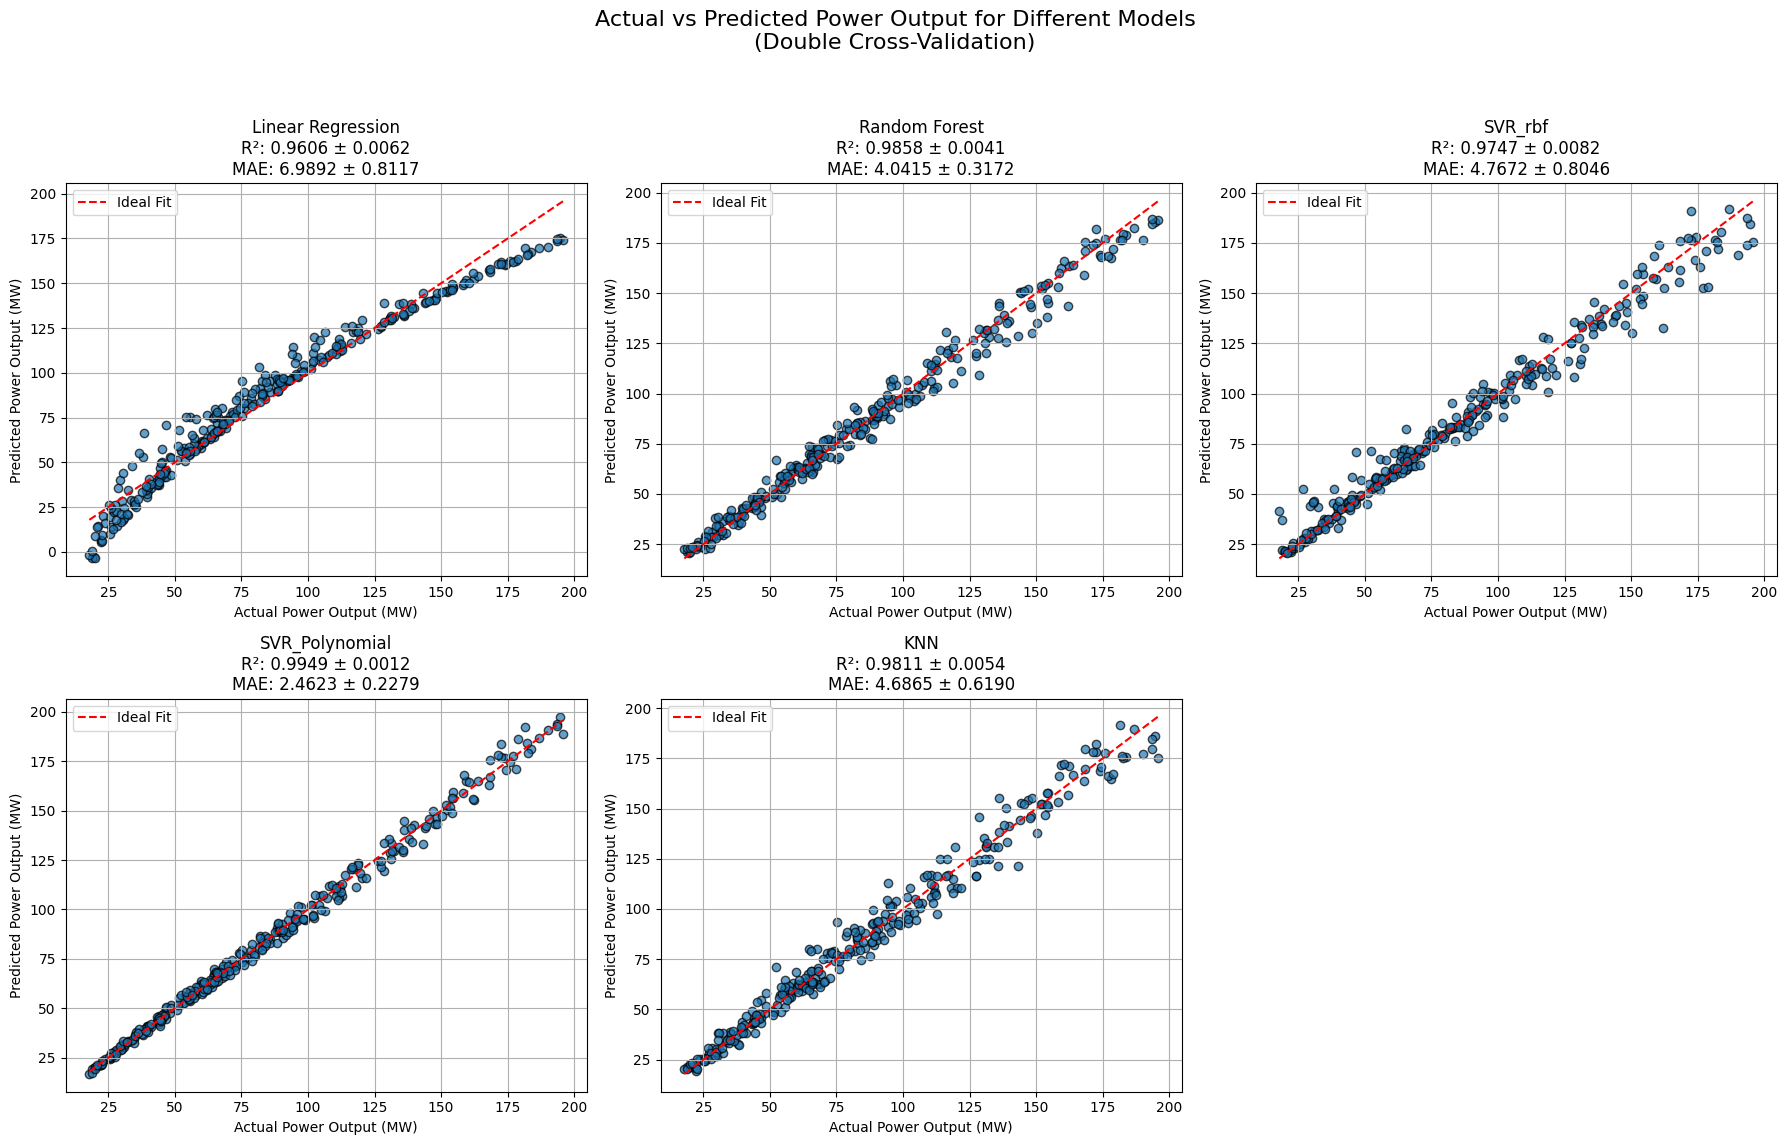

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for i, (name, res) in enumerate(results.items()):
    y_actual = res['y_actual']
    y_pred = res['y_pred']

    plt.subplot(2, 3, i + 1)
    plt.scatter(y_actual, y_pred, alpha=0.7, edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', label='Ideal Fit')

    plt.xlabel("Actual Power Output (MW)")
    plt.ylabel("Predicted Power Output (MW)")
    plt.title(f"{name}\nR²: {res['R² (Mean ± Std)']}\nMAE: {res['MAE (Mean ± Std)']}")
    plt.legend()
    plt.grid(True)

plt.suptitle("Actual vs Predicted Power Output for Different Models\n(Double Cross-Validation)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## Key Insights

- **SVR with Polynomial Kernel** outperformed all other models with an R² of **0.995**, closely modeling the non-linear physics-based relationship between input and output.
- **Random Forest** and **KNN** also showed strong performance, both capturing non-linearity effectively with minimal tuning.
- **Linear Regression**, while interpretable, underperformed compared to nonlinear models—highlighting the limits of assuming a purely linear relationship.
- **SVR with RBF Kernel**, after tuning, significantly improved its performance compared to default settings. (in default setting, the R2 was around 0.63)


# Recommendations in Cross-Model Validation

- Use Consistent Evaluation
    - Same data splits and same metrics for all models.

- Consider Trade-offs
    - Accuracy vs Interpretability (e.g., Random Forest vs Decision Tree)
    - Training Time vs Performance (e.g., Logistic Regression is faster)
- Use Cross-Validation Internally
    - Even during cross-model validation, we can apply **cross-validation** to each model for more robust comparisons.
- Don't Rely on Accuracy Alone
    - Consider precision, recall, or F1-score, especially for **imbalanced datasets**.

# Advantages of Cross-Model Validation
* Avoids Overfitting
* More Reliable Model Comparison
* Robust Performance Estimate

# Conclusion

- Cross-Model Validation ensures fair, reliable and robust evaluation of multiple models.
- Helps choose the model that generalizes best to new data while minimizing the risk of overfitting.
- Enables informed model selection based on both performance and constraints.
- it is valuable in situations where we need to select the best model for the data and avoid any biased evaluations